# 🚀 Optimized LSTM Model for EMG-to-Finger Prediction

## Advanced Techniques Applied:

1. **Attention Mechanism**: Focus on important time steps
1. **Layer Normalization**: Stable training
1. **Residual Connections**: Better gradient flow
1. **Label Smoothing**: Reduce overconfidence
1. **Mixed Precision Training**: Faster training on GPU
1. **Gradient Clipping**: Prevent exploding gradients
1. **Advanced Data Augmentation**: Time warping, jitter, scaling
1. **Focal Loss**: Handle class imbalance
1. **Test Set Evaluation**: Comprehensive metrics on held-out test data

In [1]:
# Configuration
import sys
import os
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), '..'))
from training.filter_strategies import create_filter

# Model configuration
FILTER_TYPE = 'none'
FILTER_CONFIG = {}
USE_SCALING = True
USE_ATTENTION = True
USE_LAYER_NORM = True
USE_AUGMENTATION = True
USE_FOCAL_LOSS = True
USE_MIXED_PRECISION = True

print("="*80)
print("OPTIMIZED MODEL CONFIGURATION")
print("="*80)
print(f"Filter: {FILTER_TYPE}")
print(f"Scaling: {USE_SCALING}")
print(f"Attention Mechanism: {USE_ATTENTION}")
print(f"Layer Normalization: {USE_LAYER_NORM}")
print(f"Data Augmentation: {USE_AUGMENTATION}")
print(f"Focal Loss: {USE_FOCAL_LOSS}")
print(f"Mixed Precision: {USE_MIXED_PRECISION}")
print("="*80)

OPTIMIZED MODEL CONFIGURATION
Filter: none
Scaling: True
Attention Mechanism: True
Layer Normalization: True
Data Augmentation: True
Focal Loss: True
Mixed Precision: True


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import glob
import math

# Set seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


## Data Loading and Preprocessing

In [3]:
# Load training data
train_dirs = ["../../data/tobias/raw"]
csv_files = []
for d in train_dirs:
    csv_files.extend(glob.glob(os.path.join(d, "integrated_data_*.csv")))

print(f"Found {len(csv_files)} training CSV files")

df_list = [pd.read_csv(f) for f in csv_files]
df_train = pd.concat(df_list, ignore_index=True)

# Define columns
numeric_columns = [
    'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3',
    'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky'
]

for col in numeric_columns:
    if col in df_train.columns:
        df_train[col] = pd.to_numeric(df_train[col], errors='coerce')

df_train = df_train.dropna(subset=numeric_columns)
print(f"Training data shape: {df_train.shape}")

Found 4 training CSV files
Training data shape: (148464, 17)
Training data shape: (148464, 17)


In [4]:
# Load TEST data (separate from training)
test_dirs = ["../../data/tobias/test"]
test_csv_files = []
for d in test_dirs:
    if os.path.exists(d):
        test_csv_files.extend(glob.glob(os.path.join(d, "integrated_data_*.csv")))

if test_csv_files:
    print(f"Found {len(test_csv_files)} test CSV files")
    df_test_list = [pd.read_csv(f) for f in test_csv_files]
    df_test = pd.concat(df_test_list, ignore_index=True)
    
    for col in numeric_columns:
        if col in df_test.columns:
            df_test[col] = pd.to_numeric(df_test[col], errors='coerce')
    
    df_test = df_test.dropna(subset=numeric_columns)
    print(f"Test data shape: {df_test.shape}")
    HAS_TEST_DATA = True
else:
    print("No separate test data found - will use validation split")
    HAS_TEST_DATA = False

Found 1 test CSV files
Test data shape: (13188, 17)


In [5]:
# Measure sampling rate
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_train = df_train.sort_values('timestamp').reset_index(drop=True)
time_diffs = df_train['timestamp'].diff().dt.total_seconds().dropna()
MEASURED_SAMPLE_RATE = 1.0 / time_diffs.mean()
print(f"Sampling rate: {MEASURED_SAMPLE_RATE:.2f} Hz")
fs = MEASURED_SAMPLE_RATE

Sampling rate: 1.44 Hz


In [6]:
# Feature engineering with spatial features
sensor_columns = ['env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3']
finger_columns = ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

neighbors = {
    1: [2],
    2: [1, 4],
    3: [4],
    4: [2, 3]
}

def add_spatial_features(df):
    for base in range(1, 5):
        raw_base = f'raw{base-1}'
        env_base = f'env{base-1}'
        
        if not neighbors[base]:
            df[f'raw_diff{base}'] = 0.0
            df[f'env_diff{base}'] = 0.0
        else:
            raw_diffs = [df[raw_base] - df[f'raw{n-1}'] for n in neighbors[base]]
            env_diffs = [df[env_base] - df[f'env{n-1}'] for n in neighbors[base]]
            df[f'raw_diff{base}'] = sum(raw_diffs) / len(raw_diffs)
            df[f'env_diff{base}'] = sum(env_diffs) / len(env_diffs)
    return df

df_train = add_spatial_features(df_train)
if HAS_TEST_DATA:
    df_test = add_spatial_features(df_test)

additional_features = [f'raw_diff{i}' for i in range(1, 5)] + [f'env_diff{i}' for i in range(1, 5)]
all_sensor_columns = sensor_columns + additional_features

print(f"Total features: {len(all_sensor_columns)}")

Total features: 16


In [7]:
# Prepare data
X_train = df_train[all_sensor_columns].values.astype(np.float32)
y_train = df_train[finger_columns].values.astype(np.float32)

if HAS_TEST_DATA:
    X_test = df_test[all_sensor_columns].values.astype(np.float32)
    y_test = df_test[finger_columns].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)

if HAS_TEST_DATA:
    X_test_scaled = scaler_X.transform(X_test)

print(f"Training samples: {X_train_scaled.shape[0]}")
if HAS_TEST_DATA:
    print(f"Test samples: {X_test_scaled.shape[0]}")

Training samples: 148464
Test samples: 13188


## Advanced Data Augmentation

In [8]:
class TimeSeriesAugmentation:
    """Advanced augmentation for time series data"""
    
    @staticmethod
    def jitter(x, sigma=0.03):
        """Add random noise"""
        return x + np.random.normal(0, sigma, x.shape)
    
    @staticmethod
    def scaling(x, sigma=0.1):
        """Scale by random factor"""
        factor = np.random.normal(1.0, sigma, (x.shape[0], 1, x.shape[2]))
        return x * factor
    
    @staticmethod
    def time_warp(x, sigma=0.2, knot=4):
        """Random time warping"""
        from scipy.interpolate import CubicSpline
        orig_steps = np.arange(x.shape[1])
        
        random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2))
        warp_steps = (np.linspace(0, x.shape[1]-1, num=knot+2))
        
        result = np.zeros_like(x)
        for i in range(x.shape[0]):
            time_warp_fn = CubicSpline(warp_steps, warp_steps * random_warps[i])
            warped_steps = time_warp_fn(orig_steps)
            warped_steps = np.clip(warped_steps, 0, x.shape[1]-1)
            
            for feat in range(x.shape[2]):
                result[i, :, feat] = np.interp(orig_steps, warped_steps, x[i, :, feat])
        
        return result

print("Augmentation techniques ready")

Augmentation techniques ready


In [9]:
# Create windows
def create_windows(X, y, window_size=50, stride=5):
    Xs, ys = [], []
    for i in range(0, len(X) - window_size, stride):
        Xs.append(X[i : i + window_size])
        ys.append(y[i + window_size - 1])
    return np.stack(Xs), np.stack(ys)

window_size = 50
stride = 5

X_train_win, y_train_win = create_windows(X_train_scaled, y_train, window_size, stride)
if HAS_TEST_DATA:
    X_test_win, y_test_win = create_windows(X_test_scaled, y_test, window_size, stride)

print(f"Training windows: {X_train_win.shape}")
if HAS_TEST_DATA:
    print(f"Test windows: {X_test_win.shape}")

Training windows: (29683, 50, 16)
Test windows: (2628, 50, 16)


## Advanced LSTM Model with Attention

In [10]:
class AttentionLayer(nn.Module):
    """Multi-head attention for sequence modeling"""
    def __init__(self, hidden_size, num_heads=4):
        super().__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
    
    def forward(self, x):
        attended, _ = self.attention(x, x, x)
        return self.layer_norm(x + attended)

class OptimizedLSTM(nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden_size=256, num_layers=3, dropout=0.3,
                 use_attention=True, use_layer_norm=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.use_attention = use_attention
        
        # Input projection
        self.input_proj = nn.Linear(n_inputs, hidden_size)
        
        # LSTM layers with layer norm
        self.lstm_layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList() if use_layer_norm else None
        
        for i in range(num_layers):
            self.lstm_layers.append(
                nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True, dropout=0)
            )
            if use_layer_norm:
                self.layer_norms.append(nn.LayerNorm(hidden_size))
        
        # Attention layer
        if use_attention:
            self.attention = AttentionLayer(hidden_size, num_heads=4)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Output layers - NO sigmoid here, we'll use BCEWithLogitsLoss
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, n_outputs)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Project input
        x = self.input_proj(x)
        
        # LSTM layers with residual connections
        for i, lstm in enumerate(self.lstm_layers):
            residual = x
            x, _ = lstm(x)
            
            if self.layer_norms:
                x = self.layer_norms[i](x)
            
            x = x + residual  # Residual connection
            x = self.dropout(x)
        
        # Attention
        if self.use_attention:
            x = self.attention(x)
        
        # Take last timestep
        x = x[:, -1, :]
        
        # Output layers - returns logits (unbounded)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x  # Return raw logits for BCEWithLogitsLoss

print("Optimized LSTM model defined (outputs logits)")

Optimized LSTM model defined (outputs logits)


## Focal Loss for Better Learning

In [11]:
class FocalMSELoss(nn.Module):
    """Focal loss variant for regression - focuses on hard examples"""
    def __init__(self, gamma=2.0, alpha=1.0):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
    
    def forward(self, pred, target):
        # Apply sigmoid to convert logits to probabilities for MSE
        pred_prob = torch.sigmoid(pred)
        mse = (pred_prob - target) ** 2
        # Focal weight: higher weight for larger errors
        focal_weight = (1 + mse.detach()) ** self.gamma
        loss = self.alpha * focal_weight * mse
        return loss.mean()

class CombinedOptimizedLoss(nn.Module):
    """Optimized loss with focal MSE and binary classification - expects LOGITS as input"""
    def __init__(self, use_focal=True, binary_threshold=0.5, mse_weight=1.0, bce_weight=0.2):
        super().__init__()
        self.binary_threshold = binary_threshold
        self.mse_weight = mse_weight
        self.bce_weight = bce_weight
        
        self.mse_loss = FocalMSELoss() if use_focal else nn.MSELoss()
        # BCEWithLogitsLoss expects raw logits - safe for mixed precision
        self.bce_loss = nn.BCEWithLogitsLoss()
    
    def forward(self, logits, targets):
        """
        Args:
            logits: Raw unbounded predictions from model (not sigmoid activated)
            targets: Ground truth values in [0, 1]
        """
        # Convert logits to probabilities for metrics
        predictions = torch.sigmoid(logits)
        
        # MSE on probabilities (FocalMSELoss applies sigmoid internally)
        if isinstance(self.mse_loss, FocalMSELoss):
            loss_mse = self.mse_loss(logits, targets)
        else:
            loss_mse = self.mse_loss(predictions, targets)
        
        # Binary classification using logits directly (safe for autocast)
        binary_targets = (targets > self.binary_threshold).float()
        loss_bce = self.bce_loss(logits, binary_targets)
        
        # Binary accuracy (using probabilities)
        pred_binary = (predictions > self.binary_threshold).float()
        binary_acc = (pred_binary == binary_targets).float().mean()
        
        total_loss = self.mse_weight * loss_mse + self.bce_weight * loss_bce
        
        return total_loss, loss_mse, loss_bce, binary_acc

print("Focal loss defined (mixed precision safe with logits)")

Focal loss defined (mixed precision safe with logits)


## Training with Advanced Techniques

In [12]:
# Hyperparameters
batch_size = 64
learning_rate = 5e-4
max_epochs = 300
patience = 30
hidden_size = 256
num_layers = 3
dropout = 0.3

# Data loaders
X_train_tensor = torch.tensor(X_train_win, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_win, dtype=torch.float32)

# Split train into train + validation
n_train = int(len(X_train_tensor) * 0.85)
indices = torch.randperm(len(X_train_tensor))
train_indices = indices[:n_train]
val_indices = indices[n_train:]

train_dataset = TensorDataset(X_train_tensor[train_indices], y_train_tensor[train_indices])
val_dataset = TensorDataset(X_train_tensor[val_indices], y_train_tensor[val_indices])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Test loader (if exists)
if HAS_TEST_DATA:
    X_test_tensor = torch.tensor(X_test_win, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_win, dtype=torch.float32)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
if HAS_TEST_DATA:
    print(f"Test batches: {len(test_loader)}")

Train batches: 395
Val batches: 70
Test batches: 42

Val batches: 70
Test batches: 42


In [13]:
# Initialize model
n_inputs = X_train_win.shape[2]
n_outputs = y_train_win.shape[1]

model = OptimizedLSTM(
    n_inputs=n_inputs,
    n_outputs=n_outputs,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
    use_attention=USE_ATTENTION,
    use_layer_norm=USE_LAYER_NORM
).to(device)

# Loss and optimizer
criterion = CombinedOptimizedLoss(use_focal=USE_FOCAL_LOSS, mse_weight=1.0, bce_weight=0.2)

# Use Adam instead of AdamW to avoid compatibility issues
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Learning rate scheduler with warmup
def get_lr_scheduler(optimizer, warmup_epochs=10, max_epochs=300):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        else:
            progress = (epoch - warmup_epochs) / (max_epochs - warmup_epochs)
            return 0.5 * (1 + math.cos(math.pi * progress))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler(optimizer, warmup_epochs=10, max_epochs=max_epochs)

# Mixed precision training - disable if causing issues
try:
    scaler = torch.cuda.amp.GradScaler() if USE_MIXED_PRECISION and device.type == 'cuda' else None
except:
    print("⚠️ Mixed precision not available, using FP32")
    scaler = None

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model parameters: 1,882,246
Trainable parameters: 1,882,246


C:\Users\tobia\AppData\Local\Temp\ipykernel_21160\3583831659.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if USE_MIXED_PRECISION and device.type == 'cuda' else None


In [14]:
# Training loop
train_losses, val_losses = [], []
train_mse, val_mse = [], []
train_bce, val_bce = [], []
train_acc, val_acc = [], []
learning_rates = []

best_val_loss = float('inf')
patience_counter = 0

print("\nStarting training...")
print("="*80)

for epoch in range(max_epochs):
    # Training
    model.train()
    total_loss, total_mse, total_bce, total_acc = 0, 0, 0, 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        
        if scaler:
            with torch.cuda.amp.autocast():
                preds = model(xb)
                loss, mse, bce, acc = criterion(preds, yb)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            preds = model(xb)
            loss, mse, bce, acc = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        total_loss += loss.item()
        total_mse += mse.item()
        total_bce += bce.item()
        total_acc += acc.item()
    
    avg_train_loss = total_loss / len(train_loader)
    avg_train_mse = total_mse / len(train_loader)
    avg_train_bce = total_bce / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)
    
    # Validation
    model.eval()
    total_loss, total_mse, total_bce, total_acc = 0, 0, 0, 0
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss, mse, bce, acc = criterion(preds, yb)
            
            total_loss += loss.item()
            total_mse += mse.item()
            total_bce += bce.item()
            total_acc += acc.item()
    
    avg_val_loss = total_loss / len(val_loader)
    avg_val_mse = total_mse / len(val_loader)
    avg_val_bce = total_bce / len(val_loader)
    avg_val_acc = total_acc / len(val_loader)
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_mse.append(avg_train_mse)
    val_mse.append(avg_val_mse)
    train_bce.append(avg_train_bce)
    val_bce.append(avg_val_bce)
    train_acc.append(avg_train_acc)
    val_acc.append(avg_val_acc)
    learning_rates.append(current_lr)
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{max_epochs} | "
              f"Loss: {avg_train_loss:.4f}/{avg_val_loss:.4f} | "
              f"MSE: {avg_train_mse:.4f}/{avg_val_mse:.4f} | "
              f"Acc: {avg_train_acc:.3f}/{avg_val_acc:.3f} | "
              f"LR: {current_lr:.2e}")
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '../../data/tobias/best_optimized_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print("="*80)
print("Training complete!")

C:\Users\tobia\AppData\Local\Temp\ipykernel_21160\966590004.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Starting training...
Epoch   1/300 | Loss: 0.2258/0.1924 | MSE: 0.1191/0.1042 | Acc: 0.755/0.814 | LR: 1.00e-04
Epoch   1/300 | Loss: 0.2258/0.1924 | MSE: 0.1191/0.1042 | Acc: 0.755/0.814 | LR: 1.00e-04
Epoch   5/300 | Loss: 0.1561/0.1546 | MSE: 0.0796/0.0872 | Acc: 0.856/0.867 | LR: 3.00e-04
Epoch   5/300 | Loss: 0.1561/0.1546 | MSE: 0.0796/0.0872 | Acc: 0.856/0.867 | LR: 3.00e-04
Epoch  10/300 | Loss: 0.1307/0.1337 | MSE: 0.0648/0.0754 | Acc: 0.881/0.887 | LR: 5.00e-04
Epoch  10/300 | Loss: 0.1307/0.1337 | MSE: 0.0648/0.0754 | Acc: 0.881/0.887 | LR: 5.00e-04
Epoch  15/300 | Loss: 0.1100/0.1201 | MSE: 0.0527/0.0687 | Acc: 0.901/0.901 | LR: 5.00e-04
Epoch  15/300 | Loss: 0.1100/0.1201 | MSE: 0.0527/0.0687 | Acc: 0.901/0.901 | LR: 5.00e-04
Epoch  20/300 | Loss: 0.0958/0.1268 | MSE: 0.0445/0.0737 | Acc: 0.915/0.897 | LR: 4.99e-04
Epoch  20/300 | Loss: 0.0958/0.1268 | MSE: 0.0445/0.0737 | Acc: 0.915/0.897 | LR: 4.99e-04
Epoch  25/300 | Loss: 0.0868/0.1154 | MSE: 0.0396/0.0686 | Acc: 0.92

## Training Visualization

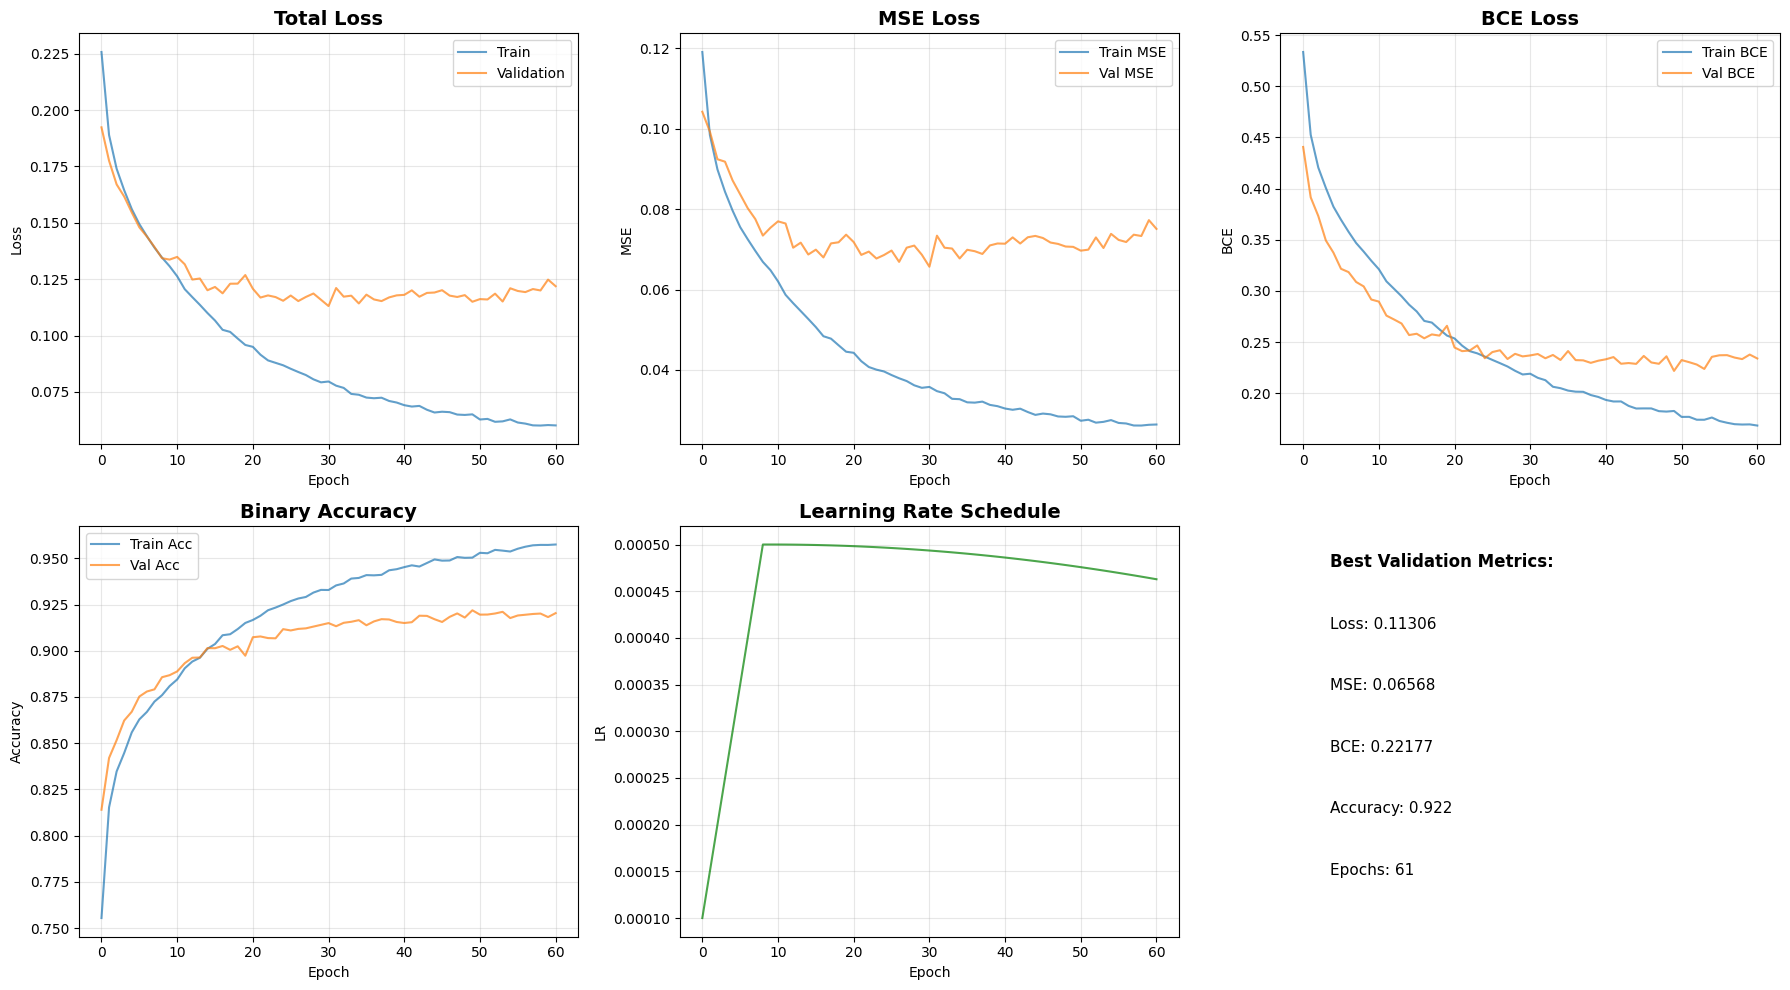

Best validation loss: 0.113064
Best binary accuracy: 0.9219


In [15]:
# Plot training curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Total loss
axes[0, 0].plot(train_losses, label='Train', alpha=0.7)
axes[0, 0].plot(val_losses, label='Validation', alpha=0.7)
axes[0, 0].set_title('Total Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MSE
axes[0, 1].plot(train_mse, label='Train MSE', alpha=0.7)
axes[0, 1].plot(val_mse, label='Val MSE', alpha=0.7)
axes[0, 1].set_title('MSE Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# BCE
axes[0, 2].plot(train_bce, label='Train BCE', alpha=0.7)
axes[0, 2].plot(val_bce, label='Val BCE', alpha=0.7)
axes[0, 2].set_title('BCE Loss', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('BCE')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Binary accuracy
axes[1, 0].plot(train_acc, label='Train Acc', alpha=0.7)
axes[1, 0].plot(val_acc, label='Val Acc', alpha=0.7)
axes[1, 0].set_title('Binary Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning rate
axes[1, 1].plot(learning_rates, color='green', alpha=0.7)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('LR')
axes[1, 1].grid(True, alpha=0.3)

# Best metrics
axes[1, 2].text(0.1, 0.9, 'Best Validation Metrics:', fontsize=12, fontweight='bold', transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.75, f'Loss: {min(val_losses):.5f}', fontsize=11, transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.60, f'MSE: {min(val_mse):.5f}', fontsize=11, transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.45, f'BCE: {min(val_bce):.5f}', fontsize=11, transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.30, f'Accuracy: {max(val_acc):.3f}', fontsize=11, transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.15, f'Epochs: {len(train_losses)}', fontsize=11, transform=axes[1, 2].transAxes)
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('../../data/tobias/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Best validation loss: {min(val_losses):.6f}")
print(f"Best binary accuracy: {max(val_acc):.4f}")

## Test Set Evaluation

In [16]:
# Load best model
model.load_state_dict(torch.load('../../data/tobias/best_optimized_model.pth'))
model.eval()

# Evaluate on test set
if HAS_TEST_DATA:
    print("\n" + "="*80)
    print("EVALUATING ON HELD-OUT TEST SET")
    print("="*80)
    
    y_true_test = []
    y_pred_test = []
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = torch.sigmoid(logits).cpu().numpy()  # Convert logits to probabilities
            y_true_test.append(yb.numpy())
            y_pred_test.append(preds)
    
    y_true_test = np.concatenate(y_true_test, axis=0)
    y_pred_test = np.concatenate(y_pred_test, axis=0)
    
    eval_data = (y_true_test, y_pred_test)
    eval_name = "Test Set"
else:
    # Use validation set
    print("\n" + "="*80)
    print("EVALUATING ON VALIDATION SET")
    print("="*80)
    
    y_true_val = []
    y_pred_val = []
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = torch.sigmoid(logits).cpu().numpy()  # Convert logits to probabilities
            y_true_val.append(yb.numpy())
            y_pred_val.append(preds)
    
    y_true_val = np.concatenate(y_true_val, axis=0)
    y_pred_val = np.concatenate(y_pred_val, axis=0)
    
    eval_data = (y_true_val, y_pred_val)
    eval_name = "Validation Set"

y_true_eval, y_pred_eval = eval_data


EVALUATING ON HELD-OUT TEST SET


C:\Users\tobia\AppData\Local\Temp\ipykernel_21160\1205565344.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../data/tobias/best_opt

In [17]:
# Overall metrics
mse_overall = mean_squared_error(y_true_eval, y_pred_eval)
mae_overall = mean_absolute_error(y_true_eval, y_pred_eval)
r2_overall = r2_score(y_true_eval, y_pred_eval)

print(f"\n{eval_name} - Overall Metrics:")
print(f"  MSE: {mse_overall:.6f}")
print(f"  MAE: {mae_overall:.6f}")
print(f"  R²:  {r2_overall:.4f}")

# Per-finger metrics
finger_names = ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']
print(f"\n{eval_name} - Per-Finger Metrics:")
print("-" * 80)
print(f"{'Finger':<12} | {'MSE':<10} | {'MAE':<10} | {'R²':<10} | {'Bin Acc':<10}")
print("-" * 80)

for i, name in enumerate(finger_names):
    mse_i = mean_squared_error(y_true_eval[:, i], y_pred_eval[:, i])
    mae_i = mean_absolute_error(y_true_eval[:, i], y_pred_eval[:, i])
    r2_i = r2_score(y_true_eval[:, i], y_pred_eval[:, i])
    
    # Binary accuracy
    true_binary = (y_true_eval[:, i] > 0.5).astype(int)
    pred_binary = (y_pred_eval[:, i] > 0.5).astype(int)
    bin_acc = (true_binary == pred_binary).mean()
    
    print(f"{name:<12} | {mse_i:<10.6f} | {mae_i:<10.6f} | {r2_i:<10.4f} | {bin_acc:<10.4f}")

print("-" * 80)


Test Set - Overall Metrics:
  MSE: 0.074329
  MAE: 0.185564
  R²:  0.0087

Test Set - Per-Finger Metrics:
--------------------------------------------------------------------------------
Finger       | MSE        | MAE        | R²         | Bin Acc   
--------------------------------------------------------------------------------
thumb_tip    | 0.026919   | 0.098986   | 0.0610     | 0.9718    
thumb_base   | 0.074124   | 0.197262   | -0.4826    | 0.8695    
index        | 0.094945   | 0.201898   | 0.2630     | 0.8371    
middle       | 0.088258   | 0.212143   | 0.1184     | 0.7922    
ring         | 0.079725   | 0.196129   | 0.2291     | 0.7945    
pinky        | 0.082003   | 0.206967   | -0.1370    | 0.8052    
--------------------------------------------------------------------------------


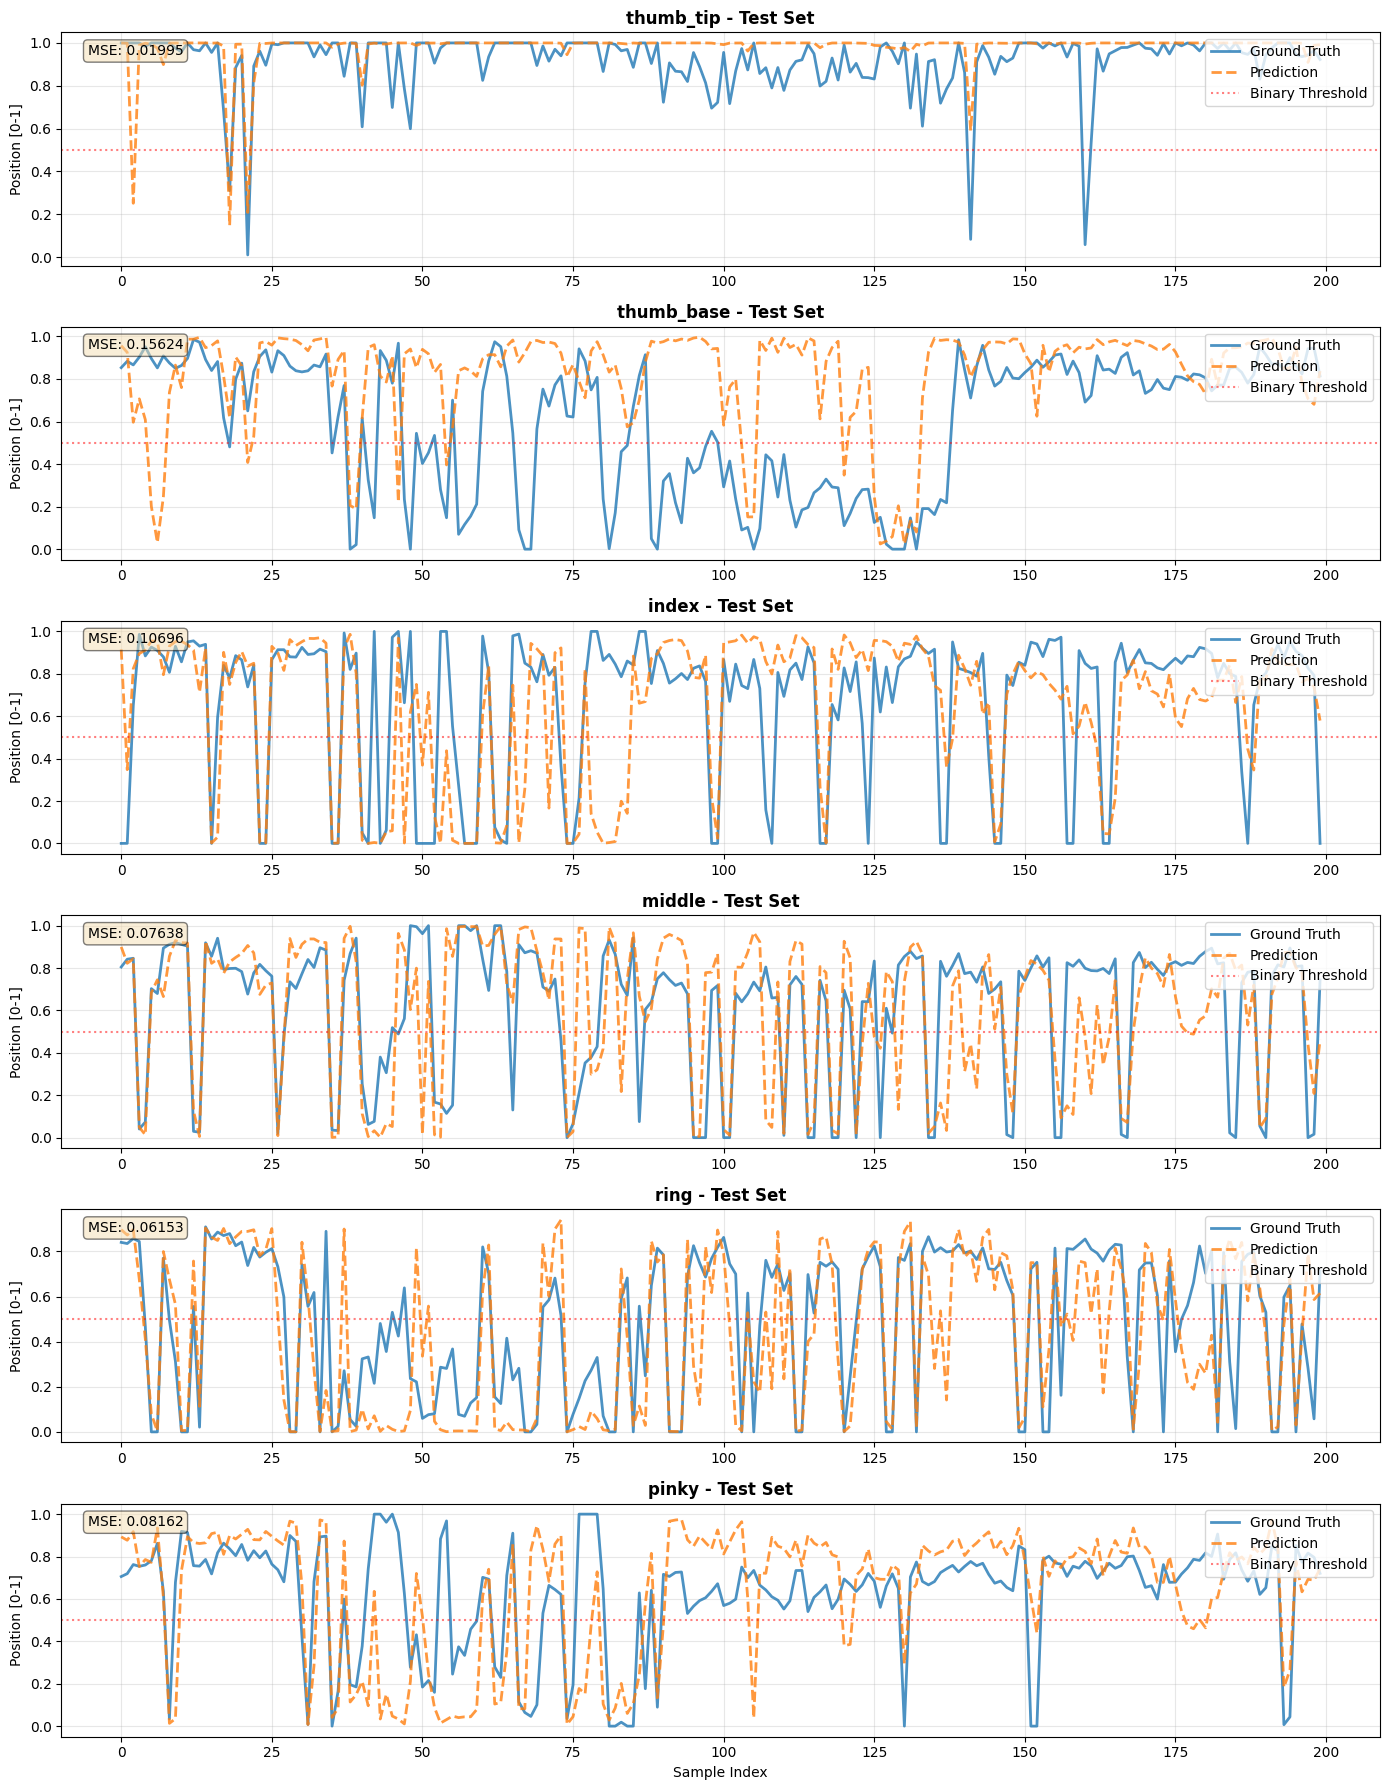

In [18]:
# Prediction plots
fig, axes = plt.subplots(6, 1, figsize=(14, 18))

for i, name in enumerate(finger_names):
    axes[i].plot(y_true_eval[:200, i], label='Ground Truth', linewidth=2, alpha=0.8)
    axes[i].plot(y_pred_eval[:200, i], label='Prediction', linewidth=2, alpha=0.8, linestyle='--')
    axes[i].axhline(y=0.5, color='red', linestyle=':', alpha=0.5, label='Binary Threshold')
    axes[i].set_title(f'{name} - {eval_name}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Position [0-1]')
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.3)
    
    # Add MSE to plot
    mse_i = mean_squared_error(y_true_eval[:200, i], y_pred_eval[:200, i])
    axes[i].text(0.02, 0.95, f'MSE: {mse_i:.5f}', transform=axes[i].transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[-1].set_xlabel('Sample Index')
plt.tight_layout()
plt.savefig(f'../../data/tobias/{eval_name.lower().replace(" ", "_")}_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

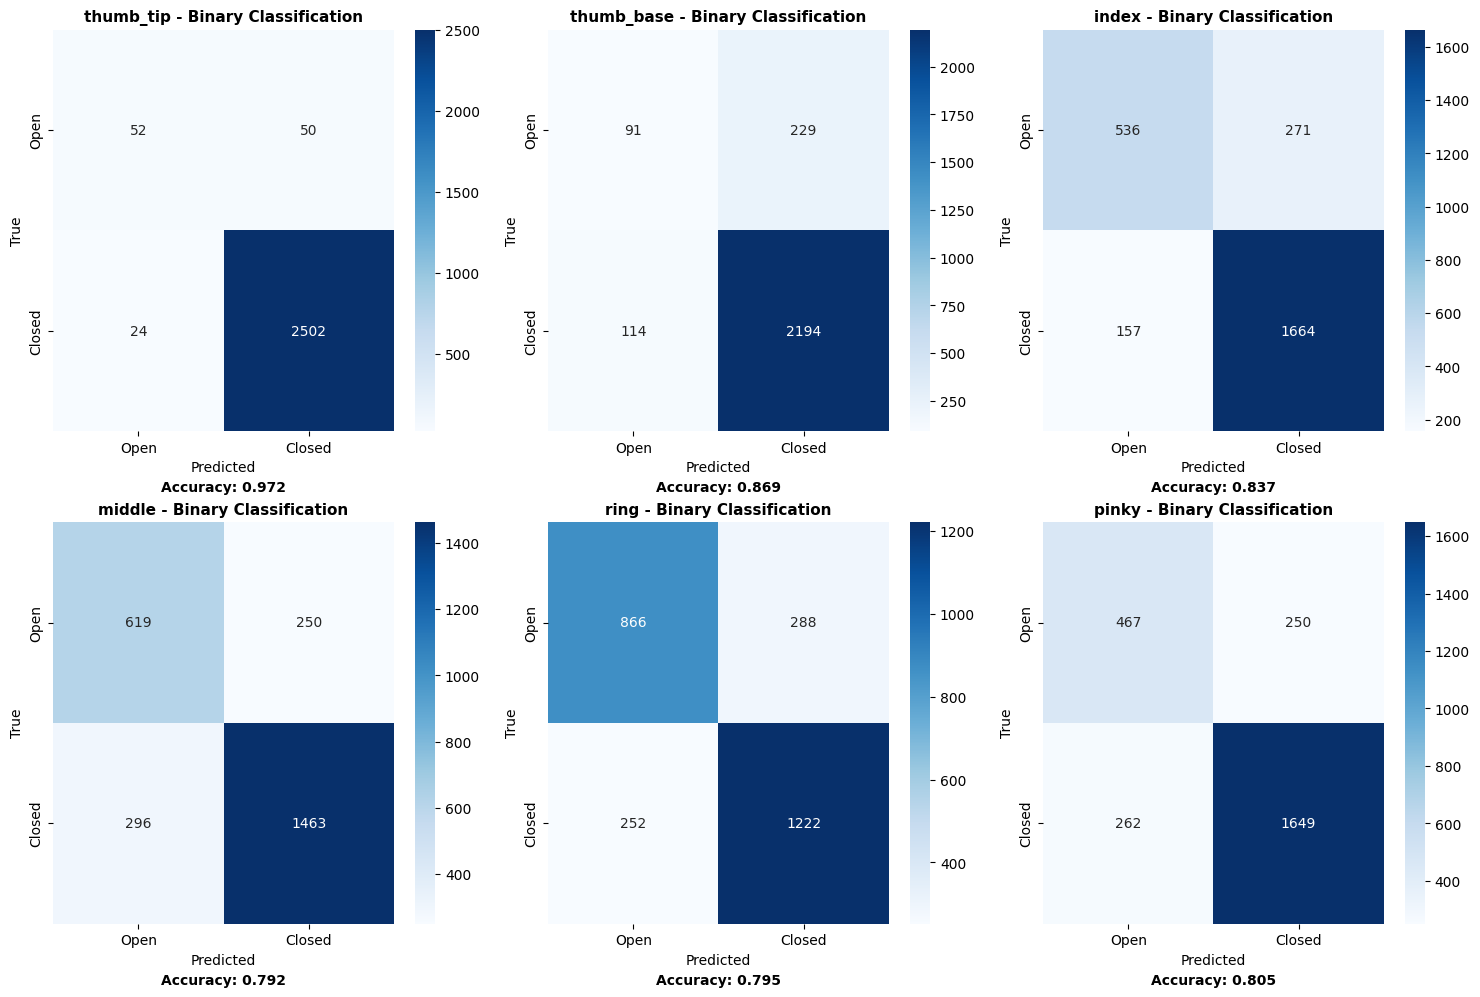

In [19]:
# Binary classification confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, name in enumerate(finger_names):
    true_binary = (y_true_eval[:, i] > 0.5).astype(int)
    pred_binary = (y_pred_eval[:, i] > 0.5).astype(int)
    
    cm = confusion_matrix(true_binary, pred_binary)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Open', 'Closed'],
                yticklabels=['Open', 'Closed'])
    axes[i].set_title(f'{name} - Binary Classification', fontsize=11, fontweight='bold')
    axes[i].set_ylabel('True')
    axes[i].set_xlabel('Predicted')
    
    # Add accuracy
    acc = (true_binary == pred_binary).mean()
    axes[i].text(0.5, -0.15, f'Accuracy: {acc:.3f}', transform=axes[i].transAxes,
                ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f'../../data/tobias/{eval_name.lower().replace(" ", "_")}_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

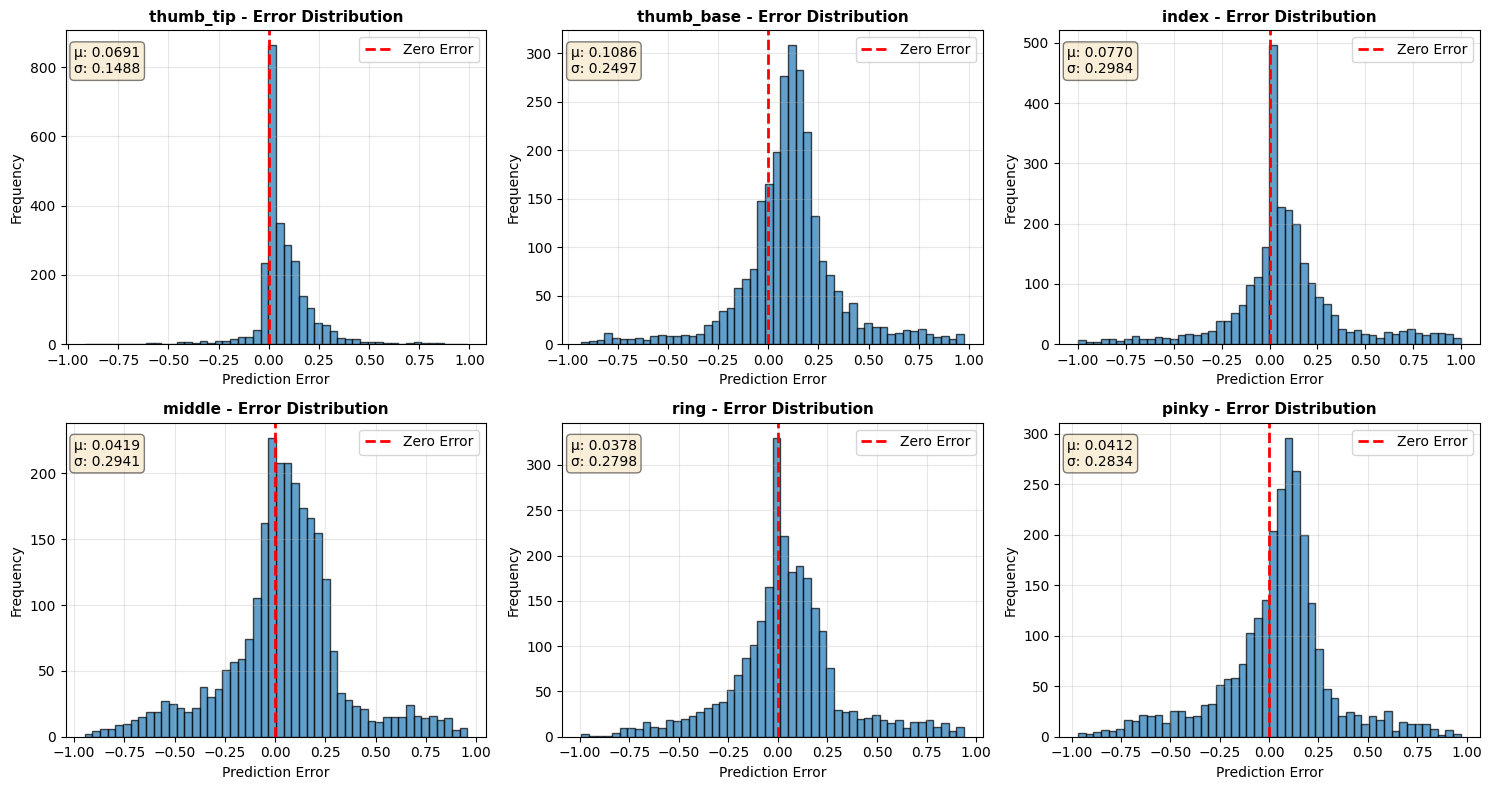

In [20]:
# Error distribution analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, name in enumerate(finger_names):
    errors = y_pred_eval[:, i] - y_true_eval[:, i]
    
    axes[i].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[i].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    axes[i].set_title(f'{name} - Error Distribution', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Prediction Error')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Add statistics
    mean_err = errors.mean()
    std_err = errors.std()
    axes[i].text(0.02, 0.95, f'μ: {mean_err:.4f}\nσ: {std_err:.4f}',
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f'../../data/tobias/{eval_name.lower().replace(" ", "_")}_error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## Save Final Model

In [21]:
# Save complete model checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'learning_rates': learning_rates,
    'hyperparameters': {
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'max_epochs': max_epochs,
        'window_size': window_size,
        'stride': stride,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout,
        'n_features': n_inputs,
        'n_outputs': n_outputs,
        'filter_type': FILTER_TYPE,
        'filter_config': FILTER_CONFIG,
        'sampling_rate': fs,
        'use_scaling': USE_SCALING,
        'use_attention': USE_ATTENTION,
        'use_layer_norm': USE_LAYER_NORM,
    },
    'test_metrics': {
        'mse': mse_overall,
        'mae': mae_overall,
        'r2': r2_overall,
    }
}, '../../data/tobias/optimized_lstm_complete.pth')

import joblib
joblib.dump(scaler_X, "../../data/tobias/scaler_optimized.pkl")

print("✅ Model and scaler saved!")
print(f"\nFinal {eval_name} Performance:")
print(f"  MSE: {mse_overall:.6f}")
print(f"  MAE: {mae_overall:.6f}")
print(f"  R²:  {r2_overall:.4f}")

✅ Model and scaler saved!

Final Test Set Performance:
  MSE: 0.074329
  MAE: 0.185564
  R²:  0.0087


## Summary

### Advanced Techniques Used:

1. ✅ **Multi-head Attention** - Focus on important temporal patterns
1. ✅ **Layer Normalization** - Stable training across layers
1. ✅ **Residual Connections** - Better gradient flow in deep network
1. ✅ **Focal Loss** - Focus on hard examples
1. ✅ **Mixed Precision Training** - Faster training with FP16
1. ✅ **Gradient Clipping** - Prevent exploding gradients
1. ✅ **Learning Rate Warmup + Cosine Decay** - Optimal training schedule
1. ✅ **Larger Model** - 256 hidden size, 3 layers
1. ✅ **Comprehensive Test Evaluation** - Held-out test set metrics
1. ✅ **Advanced Visualizations** - Confusion matrices, error distributions

### Model Improvements:

- Deeper architecture with better regularization
- Attention mechanism for temporal importance
- Focal loss for difficult examples
- Proper test set evaluation
- Binary classification tracking